In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss

import os
import datetime
import itertools


def printTime(tag):
    """
    ログ出力用の関数
    """
    print(tag + ':', datetime.datetime.now())


printTime('Inputファイルを表示')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Inputファイルを表示: 2020-03-15 21:05:23.488404
/kaggle/input/data_description_ja.md
/kaggle/input/test.csv
/kaggle/input/data_description.txt
/kaggle/input/train.csv
/kaggle/input/.ipynb_checkpoints/train-checkpoint.csv
/kaggle/input/.ipynb_checkpoints/test-checkpoint.csv
/kaggle/input/.ipynb_checkpoints/data_description-checkpoint.txt


#### 学習データの読み込み

In [67]:
train = pd.read_csv('/kaggle/input/train.csv')
test = pd.read_csv('/kaggle/input/test.csv')

# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['Id', 'SalePrice'], axis=1)
train_y = train['SalePrice']

# テストデータは特徴量のみなので、そのままでよい
test_x = test.drop(['Id'], axis=1)
test_id = test['Id']

 #### 特徴量作成

In [68]:
printTime('特徴量の作成開始')

# 解析対象とするカテゴリ列を設定
targets_category = [
                    'MSSubClass',
                    'MSZoning',
                    'Street',
                    'Alley',
                    'LotShape',
                    'LandContour',
                    'Utilities',
                    'LotConfig',
                    'LandSlope',
                    'Neighborhood',
                    'Condition1',
                    'Condition2',
                    'BldgType',
                    'HouseStyle',
                    'RoofStyle',
                    'RoofMatl',
                    'Exterior1st',
                    'Exterior2nd',
                    'MasVnrType',
                    'ExterQual',
                    'ExterCond',
                    'Foundation',
                    'BsmtQual',
                    'BsmtCond',
                    'BsmtExposure',
                    'BsmtFinType1',
                    'BsmtFinType2',
                    'Heating',
                    'HeatingQC',
                    'CentralAir',
                    'Electrical',
                    'KitchenQual',
                    'Functional',
                    'FireplaceQu',
                    'GarageType',
                    'GarageFinish',
                    'GarageQual',
                    'GarageCond',
                    'PavedDrive',
                    'PoolQC',
                    'Fence',
                    'MiscFeature',
                    'SaleType',
                    'SaleCondition']

# Dataframeの列の型がobjectのままだとLabelEncoderでエラーするため、strに変換
# ※変換処理後にinfo()で型を確認しても、objectと表示されるが内部的にはstrに変換されている。
train_x[targets_category] = train_x[targets_category].astype(str)
test_x[targets_category] = test_x[targets_category].astype(str)


# 学習データに基づいてOneHotEncodingを実施
ohe = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')
ohe.fit(train_x[targets_category])

# ダミー変数の列名の作成
columns = []
for i, c in enumerate(targets_category):
    columns += [f'{c}_{v}' for v in ohe.categories_[i]]

# 生成されたダミー変数をデータフレームに変換
dummy_vals_train = pd.DataFrame(ohe.transform(train_x[targets_category]), columns=columns)
dummy_vals_test = pd.DataFrame(ohe.transform(test_x[targets_category]), columns=columns)

# 残りの変数と結合
train_x = pd.concat([train_x.drop(targets_category, axis=1), dummy_vals_train], axis=1)
test_x = pd.concat([test_x.drop(targets_category, axis=1), dummy_vals_test], axis=1)

printTime('特徴量の作成終了')

特徴量の作成開始: 2020-03-15 21:05:24.192953
特徴量の作成終了: 2020-03-15 21:05:24.489963


#### モデル作成とバリデーション
LightGBMを使用してモデルを作成します。

モデルの作成開始: 2020-03-15 21:05:24.529294
[5]	train's l2: 4.52872e+09	valid's l2: 3.96575e+09
[10]	train's l2: 3.20619e+09	valid's l2: 2.85951e+09
[15]	train's l2: 2.33356e+09	valid's l2: 2.08677e+09
[20]	train's l2: 1.77901e+09	valid's l2: 1.66809e+09
[25]	train's l2: 1.41924e+09	valid's l2: 1.34573e+09
[30]	train's l2: 1.1518e+09	valid's l2: 1.15249e+09
[35]	train's l2: 9.49865e+08	valid's l2: 1.03826e+09
[40]	train's l2: 7.98385e+08	valid's l2: 9.79243e+08
[45]	train's l2: 7.03454e+08	valid's l2: 8.95404e+08
[50]	train's l2: 6.28503e+08	valid's l2: 8.67017e+08
[55]	train's l2: 5.82259e+08	valid's l2: 8.4571e+08
[60]	train's l2: 5.32318e+08	valid's l2: 8.18152e+08
[65]	train's l2: 4.93715e+08	valid's l2: 8.21639e+08
[70]	train's l2: 4.63922e+08	valid's l2: 8.15117e+08
[75]	train's l2: 4.4328e+08	valid's l2: 8.18663e+08
[80]	train's l2: 4.26246e+08	valid's l2: 8.20618e+08
[85]	train's l2: 4.06701e+08	valid's l2: 8.13432e+08
[90]	train's l2: 3.88675e+08	valid's l2: 7.98831e+08
[95]	train's 

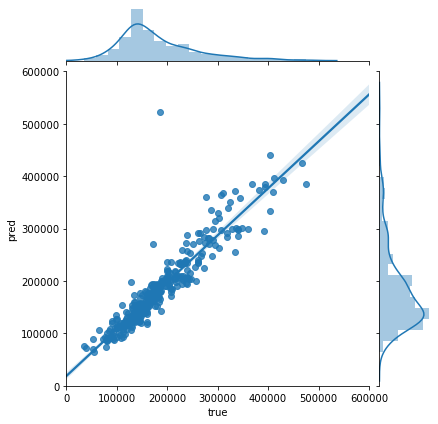

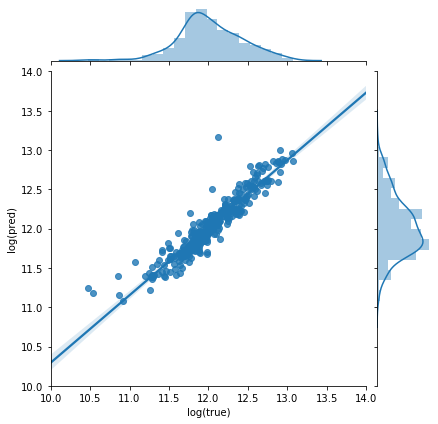

In [69]:
printTime('モデルの作成開始')

# 学習データを学習データとバリデーションデータに分ける
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

# 特徴量と目的変数をlightgbmのデータ構造に変換する
lgb_train = lgb.Dataset(tr_x, tr_y)
lgb_eval = lgb.Dataset(va_x, va_y)

# ハイパーパラメータの設定
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'max_depth': 20,
    'metric': 'l2',
    'num_leaves': 64,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l2': 2,
}

# 作成する決定木の数を指定
num_round = 100

# 学習の実行
# カテゴリ変数をパラメータで指定している
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=num_round,
                  valid_names=['train', 'valid'],
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=5)

# バリデーションデータでのスコアの確認
va_pred = model.predict(va_x)

# バリデーションデータでのスコア(真の値の対数と予測値の対数の二乗平均平方根誤差 (RMSE))を計算する
rmse = np.sqrt(mean_squared_error(np.log(va_y), np.log(va_pred)))

print(f'RMSE: {rmse:.4f}')

# 結果の可視化
sns.jointplot(
    va_y,
    va_pred,
    kind="reg",
    xlim=(0, 600000),
    ylim=(0, 600000)
).set_axis_labels("true", "pred")

sns.jointplot(
    np.log(va_y),
    np.log(va_pred),
    kind="reg",
    xlim=(10, 14),
    ylim=(10, 14)
).set_axis_labels("log(true)", "log(pred)")

# 予測
pred = model.predict(test_x)

# 提出用ファイルの作成
submission = pd.DataFrame({'Id': test_id, 'SalePrice': pred})
submission.to_csv('/kaggle/output/submission_first.csv', index=False)

printTime('モデルの作成終了')

#### データの分析にどの特徴量が重要だったのかをプロット

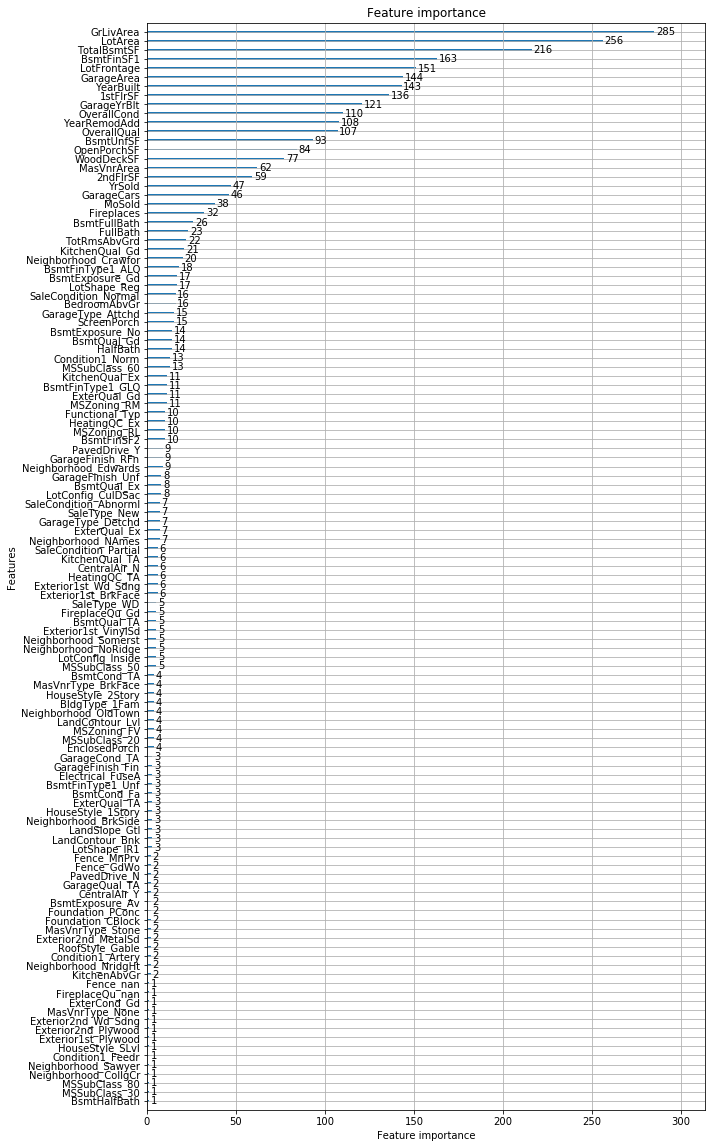

In [70]:
lgb.plot_importance(model, figsize=(10, 20))

#### 分析に使用した決定木を可視化

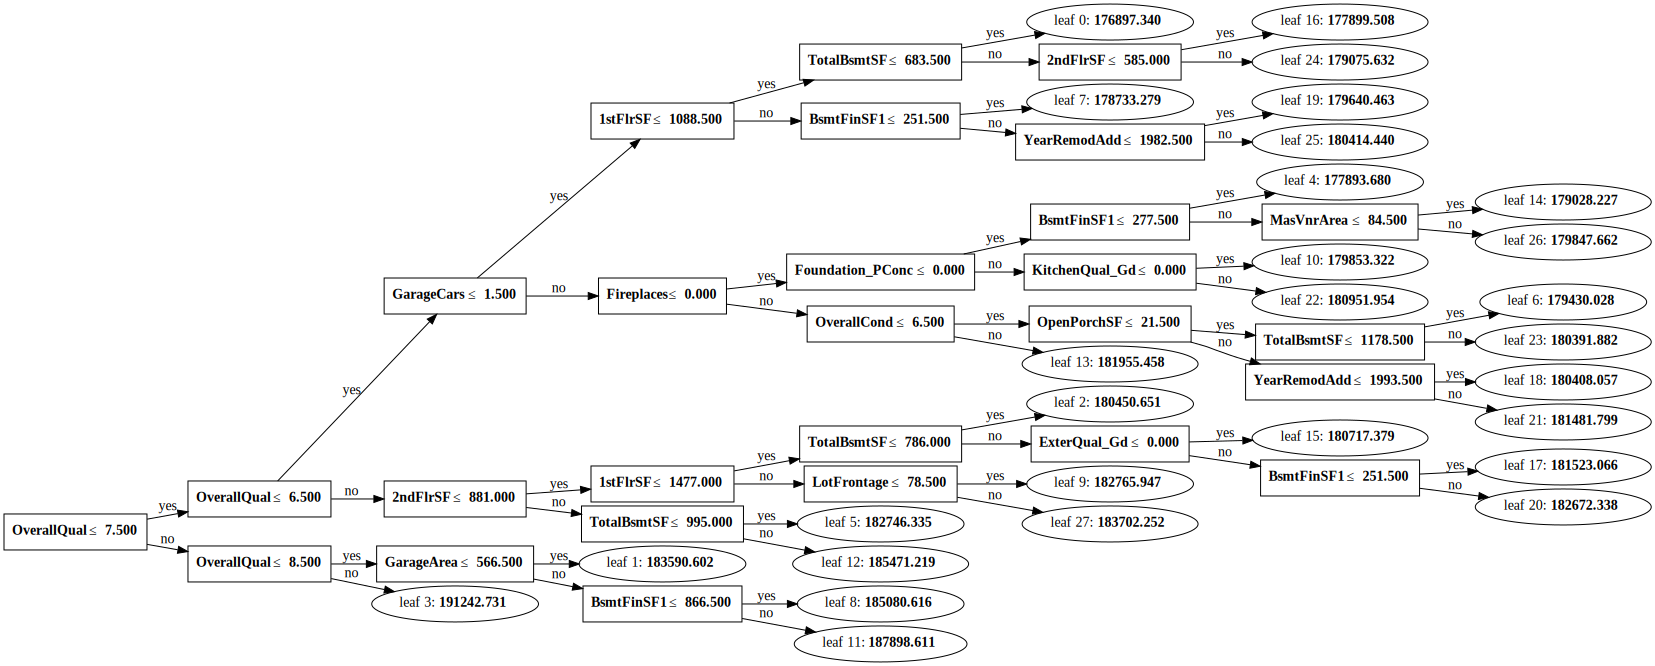

In [71]:
lgb.create_tree_digraph(model)